# GREW-MRS Thesis Project

## Run full suite simulation

The run script (`run.sh`) in the source codes' root directory is the main entrypoint for this project. It has a number of options that can be dynamically set for a wide range of simulation scenarios. This are available for reference by passing the help flag as a parameter.

In [126]:
!./run.sh -h

./run.sh usage:
        -a  Select path planning algorithm/strategy (pso, aco or lawn).
        -b  Build the main argos project. Use after editing source files.
        -d  Set the number of drones to place in simulation.
        -e  Set experiment source file. Default: "main".
        I)  Create experiment environment and install package dependancies.
        -j  Run the jupyter environment.
        -m  Set hard-limit for simulation runtime. Default: 20,000
        -n  Set number of targets/plants to place in simulation.
        N)  Set value range of targets/plants to place in simulation.
        -s  Set the number of independantly seeded trials to run.
        -t  Set the target coverage/inspection percentage during trial.
        -v  Enable argos vizualization. Disabled by default for speed.
        h | *)  Print this usage info.


The sample dataset was created with the following settings:
- Target Coverage Percentage of 90%
- Across all three path planning algorithms/strategies.
- Independantly seeding 5 random child trials per parent iteration.
- Across a range of 2 to 19 targets.

In [153]:
!./run.sh -t "0.90" -a "pso aco lawn" -s "5" -N "2 19" < pass

## Load and pre-process Dataset

In [128]:
# Import the ncessary packages.
import pandas as pd
from scipy import stats
from math import sqrt
from scipy.stats import ttest_ind
from scipy.stats import t
from scipy.stats import levene
import numpy as np
import matplotlib as plt
from math import sqrt
import statsmodels.api as sm

We first convert the csv dataset into hdf5 format for data storage and loading efficiency, and compute our sample properties thereafter.

In [141]:
chunksize = 10 ** 4
filename = 'output/data_0.csv'
headers = ['Type','TargetNum','TargetThresh','SimStep','Completed','MinimumHold','LaunchStep',
           'InitialRtMProb','RtMDelta','InitialRtLProb','RtLDelta','MinimumRest','InitialMinimumHold',
           'MaximumHold','GlobalReach','ProximityThresh','Attitude','SwarmParticles','SwarmSelfTrust',
           'SwarmPastTrust','SwarmGlobalTrust','SwarmAnts','MappingMean','MappingStdDev','MappingSeed',
           'RtMMin','RtMMax','RtMSeed','RtLMin','RtLMax','RtLSeed','ACOSeed','TaskCompletedMin',
           'TaskCompletedMax','TaskCompletedSeed','TargetShuffleMin','TargetShuffleMax',
           'TargetShuffleSeed','NaiveMapping','VStep','HStep','SimStepMax','SimTrialNum','ArgosSeed']

datatypes={
    'Type':np.string_,'TargetNum':np.uint8,'TargetThresh':np.uint8,'SimStep':np.uint32,'Completed':np.uint32,
    'MinimumHold':np.uint8,'LaunchStep':np.uint8,'InitialRtMProb':np.float16,'RtMDelta':np.float16,
    'InitialRtLProb':np.float16,'RtLDelta':np.float16,'MinimumRest':np.uint8,'InitialMinimumHold':np.uint8,
    'MaximumHold':np.uint8,'GlobalReach':np.float16,'ProximityThresh':np.float16,'Attitude':np.float16,
    'SwarmParticles':np.uint8,'SwarmSelfTrust':np.float16,'SwarmPastTrust':np.float16,'SwarmGlobalTrust':np.float16,
    'SwarmAnts':np.uint8,'MappingMean':np.float16,'MappingStdDev':np.float16,'MappingSeed':np.uint8,
    'RtMMin':np.uint8,'RtMMax':np.uint8,'RtMSeed':np.uint16,'RtLMin':np.uint8,'RtLMax':np.uint8,'RtLSeed':np.uint8,
    'ACOSeed':np.uint8,'TaskCompletedMin':np.uint8,'TaskCompletedMax':np.uint8,'TaskCompletedSeed':np.uint8,
    'TargetShuffleMin':np.uint8,'TargetShuffleMax':np.uint8,'TargetShuffleSeed':np.uint8,
    'NaiveMapping':np.uint8,'VStep':np.float16,'HStep':np.float16,
    'SimStepMax':np.uint32,'SimTrialNum':np.uint8,'ArgosSeed':np.uint8
}

def saveAsHDF(chunk):
    chunk.loc[chunk['Type'] == 'pso'].to_hdf('output/pso.h5',  key = 'data', mode ='a', format='table', append = True)
    chunk.loc[chunk['Type'] == 'aco'].to_hdf('output/aco.h5',  key = 'data', mode ='a', format='table', append = True)
    chunk.loc[chunk['Type'] == 'lawn'].to_hdf('output/lawn.h5',  key = 'data', mode ='a', format='table', append = True)

for chunk in pd.read_csv(filename, chunksize=chunksize, dtype=datatypes):
    saveAsHDF(chunk)

In [142]:
# We then re-load our categorised hdf5 datasets piecemeal and compute their means.

pso = pd.read_hdf('output/pso.h5', 'data')
aco = pd.read_hdf('output/aco.h5', 'data')
lawn = pd.read_hdf('output/lawn.h5', 'data')
means = pd.DataFrame(columns=['pso', 'aco', 'lawn'])

means.pso = pso.groupby('TargetNum').mean()['SimStep']
means.aco = aco.groupby('TargetNum').mean()['SimStep']
means.lawn = lawn.groupby('TargetNum').mean()['SimStep']

print(means)

               pso      aco     lawn
TargetNum                           
1              2.0      2.0      2.0
2            547.4    547.2   1108.0
3            548.6   1733.2   2144.4
4           5447.0   5447.0   5258.0
5           4559.4   5573.8  12269.0
6           4330.0   5025.6  16109.8
7           5249.6   4908.4  13759.0
8           4792.2   4798.0  15863.0
9           3745.4   4769.0  14957.2
10          6678.8   4761.8  17078.8
11          5054.0   2106.6  15673.0
12          2174.2   2168.4  15319.6
13          5976.8   5991.0  17299.4
14          5054.4   3224.6  16612.2
15          6288.8   9220.6  18502.0
16          3285.6   3285.8  18051.6
17          8141.4   6227.4  17336.2
18         14865.2  13041.2  18477.0
19         16711.4  13027.8  18062.8


## Data Analysis

We visualize the plots to determine what their distributions may look like.

<IPython.core.display.Javascript object>


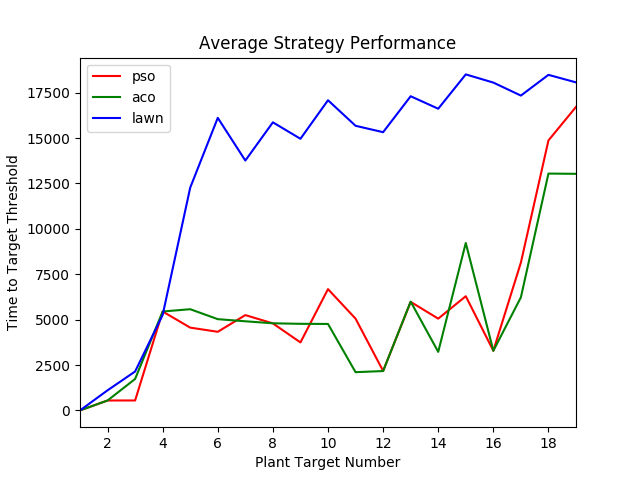

In [155]:
# Let's plot the mean values of each strategy
%matplotlib notebook
m_plot = means.plot(kind='line', style=['r', 'g', 'b']) 
m_plot.set_title('Average Strategy Performance')
m_plot.set_xlabel('Plant Target Number')
m_plot.set_ylabel('Time to Target Threshold') 
m_plot_fig = m_plot.get_figure()
m_plot_fig.savefig('thesis/images/mean_line_plots.png', bbox_inches='tight')

We can also plot the strategy performances in bar charts to better infer their distribution.

<IPython.core.display.Javascript object>


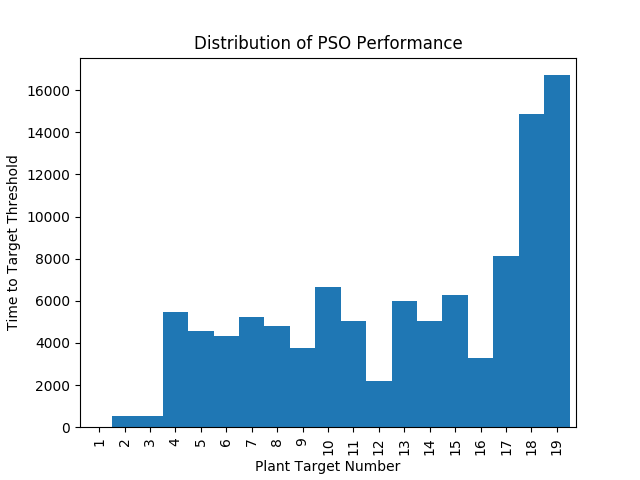

In [144]:
%matplotlib notebook

pso_plot = means.pso.plot.bar(width=1)
pso_plot.set_title('Distribution of PSO Performance')
pso_plot.set_xlabel('Plant Target Number')
pso_plot.set_ylabel('Time to Target Threshold')
pso_fig = pso_plot.get_figure()
pso_fig.savefig('thesis/images/pso_bar.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


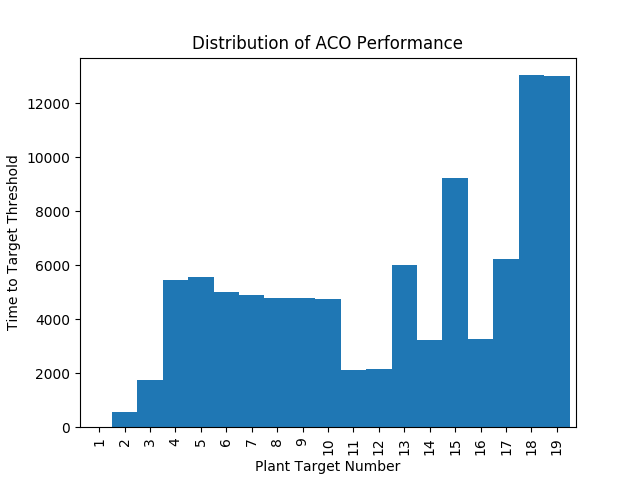

In [145]:
%matplotlib notebook
aco_plot = means.aco.plot.bar(width=1)
aco_plot.set_title('Distribution of ACO Performance')
aco_plot.set_xlabel('Plant Target Number')
aco_plot.set_ylabel('Time to Target Threshold')
aco_fig = aco_plot.get_figure()
aco_fig.savefig('thesis/images/aco_bar.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


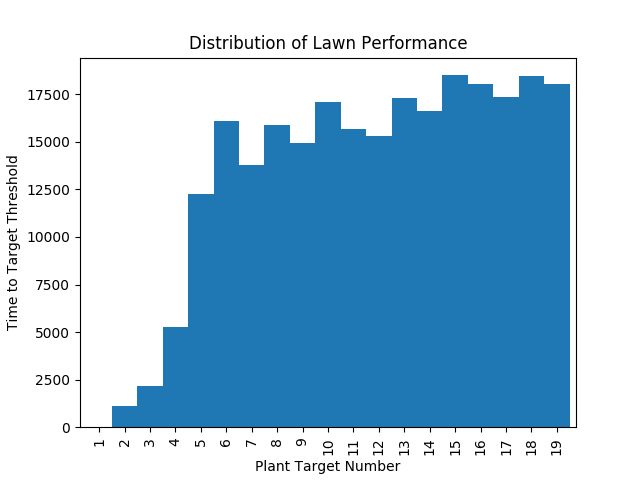

In [146]:
%matplotlib notebook

lawn_plot = means.lawn.plot.bar(width=1)
lawn_plot.set_title('Distribution of Lawn Performance')
lawn_plot.set_xlabel('Plant Target Number')
lawn_plot.set_ylabel('Time to Target Threshold')
lawn_fig = lawn_plot.get_figure()
lawn_fig.savefig('thesis/images/lawn_bar.png',bbox_inches='tight')

As can be seen in the figure above, there is a marked variability in the mean performance of the strategies, but a generally linear trend can be assumed to be present.

<IPython.core.display.Javascript object>


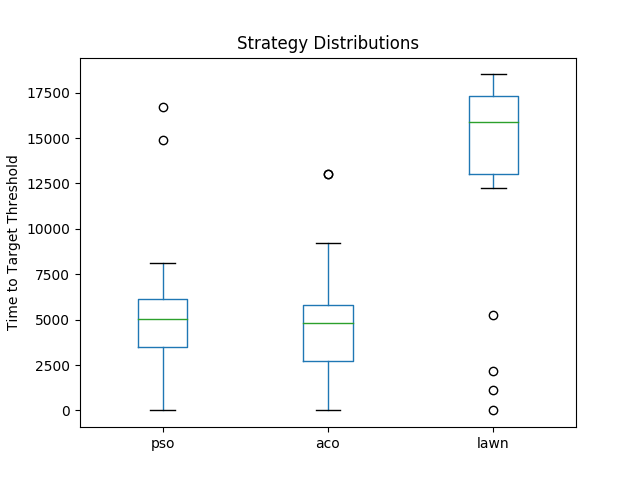

In [147]:
# We can comparatively visualize the distributions using a box plot
%matplotlib notebook

m_plot_box = means.plot.box()
m_plot_box.set_title('Strategy Distributions')
m_plot_box.set_ylabel('Time to Target Threshold')
m_plot_box_fig = m_plot_box.get_figure()
m_plot_box_fig.savefig('thesis/images/mean_box_plots.png',bbox_inches='tight')

We then identify the shape of our data distributions using Quantile-Quantile (Q-Q) plots. In the Q-Q plots below, the quantiles of our sample distributions are plotted against quantiles of a normal distribution as a scatter plot.

<IPython.core.display.Javascript object>


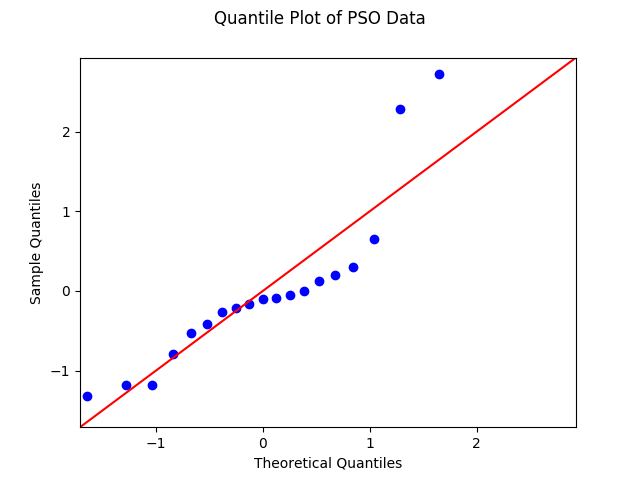

<IPython.core.display.Javascript object>


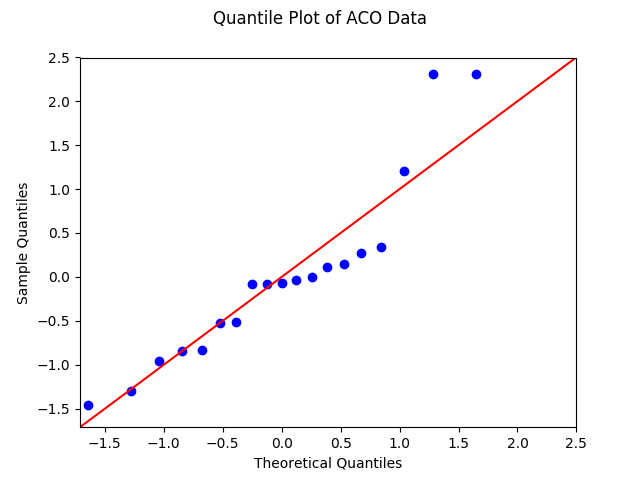

<IPython.core.display.Javascript object>


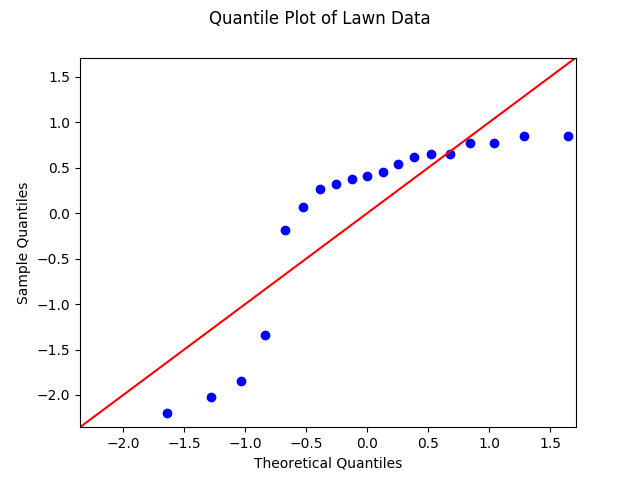

In [148]:
# We use statsmodels qqplot feature to test our distributions.
%matplotlib notebook
pso_qq_fig = sm.qqplot(means.pso, line='45', fit=True)
aco_qq_fig = sm.qqplot(means.aco, line='45', fit=True)
lawn_qq_fig = sm.qqplot(means.lawn, line='45', fit=True)

pso_qq_fig.suptitle('Quantile Plot of PSO Data')
aco_qq_fig.suptitle('Quantile Plot of ACO Data')
lawn_qq_fig.suptitle('Quantile Plot of Lawn Data')

pso_qq_fig.savefig('thesis/images/pso_qq.png',bbox_inches='tight')
aco_qq_fig.savefig('thesis/images/aco_qq.png',bbox_inches='tight')
lawn_qq_fig.savefig('thesis/images/lawn_qq.png',bbox_inches='tight')

It can be visually estimated that our data is normally distributed as the presented datasets generally follow their plotted diagonal lines. We could additionally use Scipys' normaltest utility to determine this normality, noting that the kurtosis test is only valid for sample sizes greater than or equal to 20.

In [149]:
ntest_pso = stats.normaltest(means.pso)
ntest_aco = stats.normaltest(means.aco)
ntest_lawn = stats.normaltest(means.lawn)

print('The results of the normality tests are: \nPSO: -> tc-value = {:4.3f} tp-value = {:4.3f} \nACO: -> tc-value = {:4.3f} tp-value = {:4.3f} \nLAWN: -> tc-value = {:4.3f} tp-value = {:4.3f}'.format(
    ntest_pso[0],ntest_pso[1],ntest_aco[0],ntest_aco[1],ntest_lawn[0],ntest_lawn[1]))

The results of the normality tests are: 
PSO: -> tc-value = 11.144 tp-value = 0.004 
ACO: -> tc-value = 5.515 tp-value = 0.063 
LAWN: -> tc-value = 6.670 tp-value = 0.036


/media/jo/All/Linux/thesis/source/env/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
/media/jo/All/Linux/thesis/source/env/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))
/media/jo/All/Linux/thesis/source/env/lib/python3.5/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


Before we can evaluate the result of this normality test, we must define our significance level ($\alpha$) that specifies the probability of rejecting the null hypothesis when it is actually true. In this experiment, we elect to set the significance level of the statistical test to 0.05 as is common in the literature. The goal of a statistical test is to try and reject the null hypothesis.

We can now evaluate the result of our algorithmic normality test which returned p-values lower than our alpha level (0.05), indicating a rejection of the null hypothesis that the distributions are normal. However, the sample dataset generated only has $n=19$ and was surmised to have skewed our tepid normality results as evidenced in the api output. If normality was not proveable in the exact sense, we could perform log, square root, or inverse transformations on our original data which $\textbf{may}$ have led to better approximations to the normal distribution.

<IPython.core.display.Javascript object>


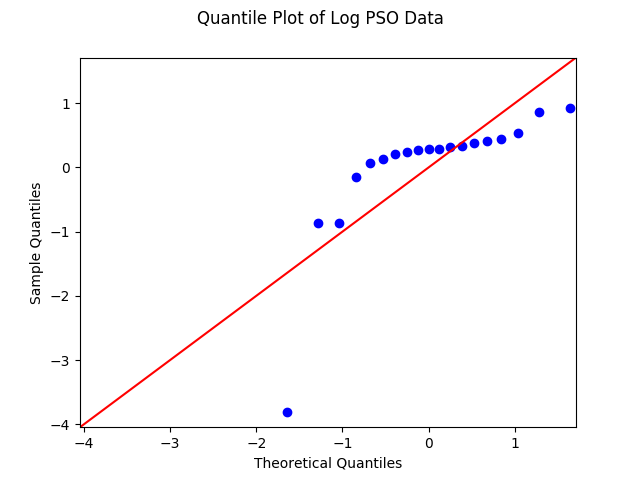

<IPython.core.display.Javascript object>


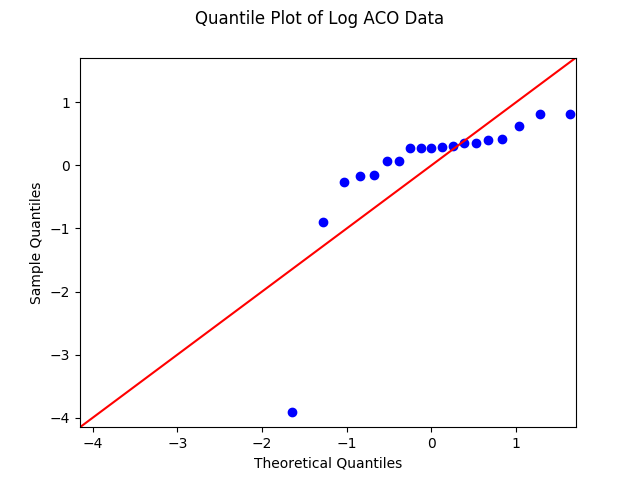

<IPython.core.display.Javascript object>


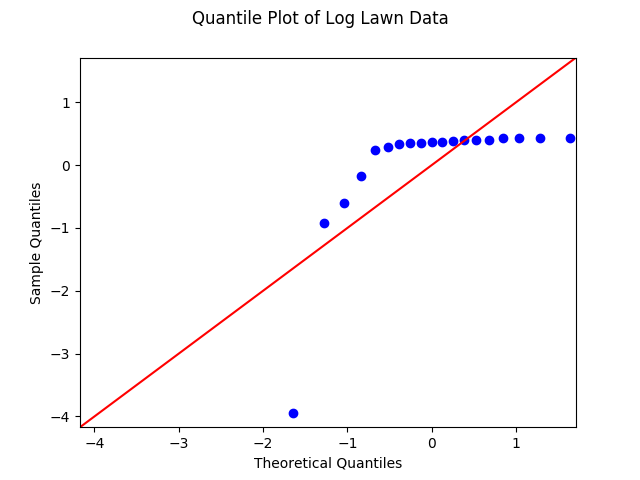

In [154]:
# We could perform a log transformation in the event that our original data proved non-normal.
# This doesn't guarantee normality, but is merely a technique used in the literature.
%matplotlib notebook
pso_qq_fig = sm.qqplot(np.log(means.pso), line='45', fit=True)
aco_qq_fig = sm.qqplot(np.log(means.aco), line='45', fit=True)
lawn_qq_fig = sm.qqplot(np.log(means.lawn), line='45', fit=True)
pso_qq_fig.suptitle('Quantile Plot of Log PSO Data')
aco_qq_fig.suptitle('Quantile Plot of Log ACO Data')
lawn_qq_fig.suptitle('Quantile Plot of Log Lawn Data')

pso_qq_fig.savefig('thesis/images/pso_log_qq.png',bbox_inches='tight')
aco_qq_fig.savefig('thesis/images/aco_log_qq.png',bbox_inches='tight')
lawn_qq_fig.savefig('thesis/images/lawn_log_qq.png',bbox_inches='tight')

We have proven normality and now must prove homoscedasticity. A number of tests exist to perform this check, including:
- Bartlett’s Test (parametric)
- Levene’s Test (parametric)
- Fligner's Test (non-parametric)

They exhibit decreasing sensitivity to strong departures from normality with Fligner's being the most robust. We limit ourselves to these tests as they have implementations in the SciPy Python library. We take a middle-of-the-road approach and go for Levene's Test as computed below.

In [151]:
lev_pa = levene(means.pso,means.aco)
lev_pl = levene(means.pso,means.lawn)
lev_al = levene(means.aco,means.lawn)

print('The results of the homoscedasticity tests are: \nPSO: -> tw-value = {:4.3f} tp-value = {:4.3f} \nACO: -> tw-value = {:4.3f} tp-value = {:4.3f} \nLAWN: -> tw-value = {:4.3f} tp-value = {:4.3f}'.format(
    lev_pa[0],lev_pa[1],lev_pl[0],lev_pl[1],lev_al[0],lev_al[1]))

The results of the homoscedasticity tests are: 
PSO: -> tw-value = 0.063 tp-value = 0.803 
ACO: -> tw-value = 0.960 tp-value = 0.334 
LAWN: -> tw-value = 1.475 tp-value = 0.232


As can be seen in the above result, our homoscedasticity test p-values are higher than our alpha level (0.05) which means we have failed to reject the null hypothesis that the distributions exhibit equal variances. If homoscedasticity could not be determinably proven, we could elect to use Welsch's t-Test that works better with unequal sample variances. Alternatively, we could perform a variable transformation such as a Box-Cox transformation.

We can now perform our t-test, where sample independance is assured on account of the simulation random-trialling mentioned previously. We shall use the independant, two-sample t-test as shown below:

## Perform Hypothesis Test

In [152]:
# Run independent two-sample, t-tests
ind_t_test_pa = ttest_ind(means.pso,means.aco)
ind_t_test_pl = ttest_ind(means.pso,means.lawn)
ind_t_test_al = ttest_ind(means.aco,means.lawn)

print('The results of the independent t-tests are: \nPSO:ACO -> tt-value = {:4.3f} tp-value = {:4.3f} \nPSO:LAWN -> tt-value = {:4.3f} tp-value = {:4.3f} \nACO:LAWN -> tt-value = {:4.3f} tp-value = {:4.3f}'.format(
    ind_t_test_pa[0],ind_t_test_pa[1],ind_t_test_pl[0],ind_t_test_pl[1],ind_t_test_al[0],ind_t_test_al[1]))

The results of the independent t-tests are: 
PSO:ACO -> tt-value = 0.315 tp-value = 0.755 
PSO:LAWN -> tt-value = -4.577 tp-value = 0.000 
ACO:LAWN -> tt-value = -5.051 tp-value = 0.000


For completeness, we performed a t-test on our pso and aco samples and got a p-value of ~0.755, indicating that there is no statistically significant difference between the two means. More interestingly though, and of central importance to this work, we have p-values of < $\alpha$ (0.05) for the pso-lawn and aco-lawn tests, which is an indication of statistically significant difference between their means. This means we can assuredly reject our null hypothesis in these scenarios.